In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np


from scipy.stats import pearsonr,spearmanr

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.axes_grid1 import make_axes_locatable
import umap

from load_data import AMLData, cluster_colors, load_table


UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.7.0) is available. Your version (2.6.0) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.7.0 release notes

https://python-docs.synapse.org/build/html/news.html



Welcome, James Pino!



In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['font.family'] = ['arial']
matplotlib.rcParams['font.size'] = 6

sns.set_theme(context ='paper', 
    palette="Paired", 
    style='white',
    font='arial',
    font_scale=1.0)

In [3]:
drugs_to_focus = [
    'Panobinostat',
    'Gilteritinib',
    'Venetoclax',
    'Sorafenib',
    'Quizartinib (AC220)',
    'Trametinib (GSK1120212)',
]

In [173]:
# feature_df = load_table('syn31854061')
feature_df = pd.read_csv('gbt_full_data_select_drugs.csv')
# feature_df = pd.read_csv('gbt_all_drugs_full_data_model_features.csv')
del feature_df['Unnamed: 0']
del feature_df['model']

In [174]:
feature_df['feature_names'] = feature_df['feature_names'].str.split('|')
feature_df['feature_scores'] = feature_df['feature_scores'].str.split('|')
feature_df['feature_scores'] = feature_df.feature_scores.apply(np.array, dtype=int)

In [6]:
# point of access for all data
data = AMLData()

significant not in columns.
p_value not in columns.


In [175]:
selected_drugs = data.auc_table[drugs_to_focus].copy()
# selected_drugs.dropna(subset=['Venetoclax', 'Panobinostat'],  inplace=True)
selected_drugs.head()

,Panobinostat,Gilteritinib,Venetoclax,Sorafenib,Quizartinib (AC220),Trametinib (GSK1120212)
sample_id,,,,,,
11-00261,NaN,NaN,NaN,227.353785,119.639393,NaN
11-00376,NaN,NaN,NaN,140.517981,142.364729,NaN
11-00378,NaN,NaN,NaN,219.576749,NaN,NaN
11-00382,NaN,NaN,NaN,211.209502,243.542792,NaN
11-00388,NaN,NaN,NaN,115.214004,77.178534,NaN


In [176]:
feature_df.head()

,feature_names,feature_scores,n_feat,mae,r2,pearson,spearman,pr,sr,source_data,drug_name
0,"[ING4_prot, BCL2_prot, AAMDC_prot, WNK1_prot, ...","[32, 29, 18, 17, 15, 12, 11, 11, 9, 9, 9, 9, 8...",135,28.982468,0.845826,0.950101,0.964444,1.217578e-13,2.246752e-15,phospho_proteomics,Venetoclax
1,"[BAZ2A_prot, IL1RAP_prot, NEDD8_prot, RAF1_pro...","[38, 24, 23, 18, 17, 15, 14, 11, 11, 11, 10, 9...",120,48.355406,0.598738,0.924046,0.907692,1.644400e-11,1.566111e-10,phospho_proteomics,Sorafenib
2,"[LCP2_prot, KCTD12-S187s, EPDR1_prot, FAM49B_p...","[30, 19, 16, 12, 12, 11, 11, 11, 10, 9, 8, 8, ...",173,24.058199,0.859140,0.960940,0.920000,9.285664e-14,2.037425e-10,phospho_proteomics,Panobinostat


In [177]:
class DrugFeatures(object):
    def __init__(self, drug_name):
        self.drug_name = drug_name
        self.data = feature_df.loc[feature_df.drug_name.isin([self.drug_name])].copy()
#         self.wes = self.ret('wes')
#         self.prot = self.ret('proteomics')
#         self.rna_seq = self.ret('rna_seq')
#         self.phospho = self.ret('phospho')
        self.proteome = self.ret('phospho_proteomics')
#         self.combo = self.ret('phospho_proteomics_rna_seq')
    def ret(self, name):
        _df = self.data.loc[self.data.source_data==name]
        return pd.Series(
            data=_df.feature_scores.values[0],
            index=_df.feature_names.values[0]
        )

In [178]:
vent = DrugFeatures('Venetoclax')
pano = DrugFeatures('Panobinostat')
sora = DrugFeatures('Sorafenib')

In [119]:
sora.proteome[sora.proteome>5].head(5)

EIF1_prot      33
ORC1_prot      24
MBD1_prot      23
MINK1-S641s    22
STK11_prot     17
dtype: int32

In [54]:
def plot_all_features(features, yticklabels=False):
    
    test = data.exp_data.species.subset(
        features,
        index='label'
    )
    
    prot = test.pivoter(
        index='label', 
        values='exp_value',
        columns='sample_id'
    )
    
    # create cluster labels for top
    node_labels = data.meta['Cluster']
    node_lut = dict(zip(sorted(node_labels.unique()), cluster_colors))
    node_colors = pd.Series(node_labels, index=data.meta.index.values, name='Cluster').map(node_lut)
    handles = [Patch(facecolor=node_lut[name]) for name in node_lut]
    
    # create venetoclax sens labels for top
    df = data.auc_table.copy()
    df.dropna(subset=['Venetoclax'], inplace=True)
    df['vent_sens'] = False
    df.loc[df.Venetoclax<100, 'vent_sens'] = True
    
    # add second colors
    node_labels2 = df.vent_sens
    node_lut2 = dict(zip(sorted(node_labels2.unique()), ['grey', 'black']))
    node_colors2 = pd.Series(node_labels2, index=df.index.values, name='Vent Sens').map(node_lut2)
    handles2 = [Patch(facecolor=node_lut2[name]) for name in node_lut2]
    
    
    # create venetoclax sens labels for top
    df = data.auc_table.copy()
    df.dropna(subset=['Panobinostat'], inplace=True)
    df['Panobinostat_sens'] = False
    df.loc[df.Panobinostat<100, 'Panobinostat_sens'] = True
    
    # add second colors
    node_labels3 = df.Panobinostat_sens
    node_lut3 = dict(zip(sorted(node_labels3.unique()), ['grey', 'black']))
    node_colors3 = pd.Series(node_labels3, index=df.index.values, name='Panobinostat_sens').map(node_lut3)
    handles3 = [Patch(facecolor=node_lut3[name]) for name in node_lut3]
    
    
    
    add_cols=False
    
    if add_cols:
        in_all_three_nodes = set(node_colors.index).intersection(node_colors3.index).intersection(node_colors2.index)
        in_all_three_nodes = set(prot.columns).intersection(in_all_three_nodes)
        prot = prot[in_all_three_nodes]
        node_colors= pd.concat([node_colors, node_colors2, node_colors3], axis=1)
    else:
        in_all_nodes = set(prot.columns).intersection(node_colors.index)
        prot = prot[in_all_nodes]
        
    vmax = 2
    sns.clustermap(
        prot.fillna(0),
        mask=prot.isnull(),
        figsize=(12, 12),
        z_score=0,
        row_cluster=True,
        col_cluster=True,
        method='ward',
        metric='correlation',
        col_colors= node_colors,
        vmax=vmax, 
        vmin=-1*vmax,
        yticklabels=yticklabels,
        xticklabels=False,
        cmap=sns.color_palette("RdBu_r", 11)
    #     linewidths=0.001

    )

    plt.legend(
        handles, node_lut, title='Cluster',
        bbox_to_anchor=(1.1, .8),
        bbox_transform=plt.gcf().transFigure,
        loc='upper right'
    )
    
#     plt.legend(
#         handles2, node_lut2, title='Ventoclax\n Sensitivity',
#         bbox_to_anchor=(1.1, .6),
#         bbox_transform=plt.gcf().transFigure,
#         loc='upper right'
#     )
    return prot

In [13]:
from magine.plotting.venn_diagram_maker import create_venn2, create_venn3

meta NOT subset; don't know how to subset; dropped


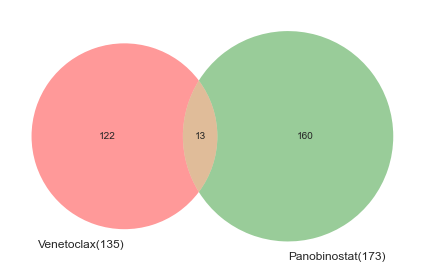

In [55]:
v = set(vent.proteome[vent.proteome>0].index.values)
p = set(pano.proteome[pano.proteome>0].index.values)
create_venn2(v, p, 'Venetoclax', 'Panobinostat',)
plt.savefig('venn_feature_overlap_vent_pan2.png', bbox_inches='tight', dpi=300)
plt.savefig('venn_feature_overlap_vent_pan2.pdf', bbox_inches='tight', dpi=300)
# th = p.intersection(v).intersection(s)
ven_and_pano = p.union(v)

meta NOT subset; don't know how to subset; dropped


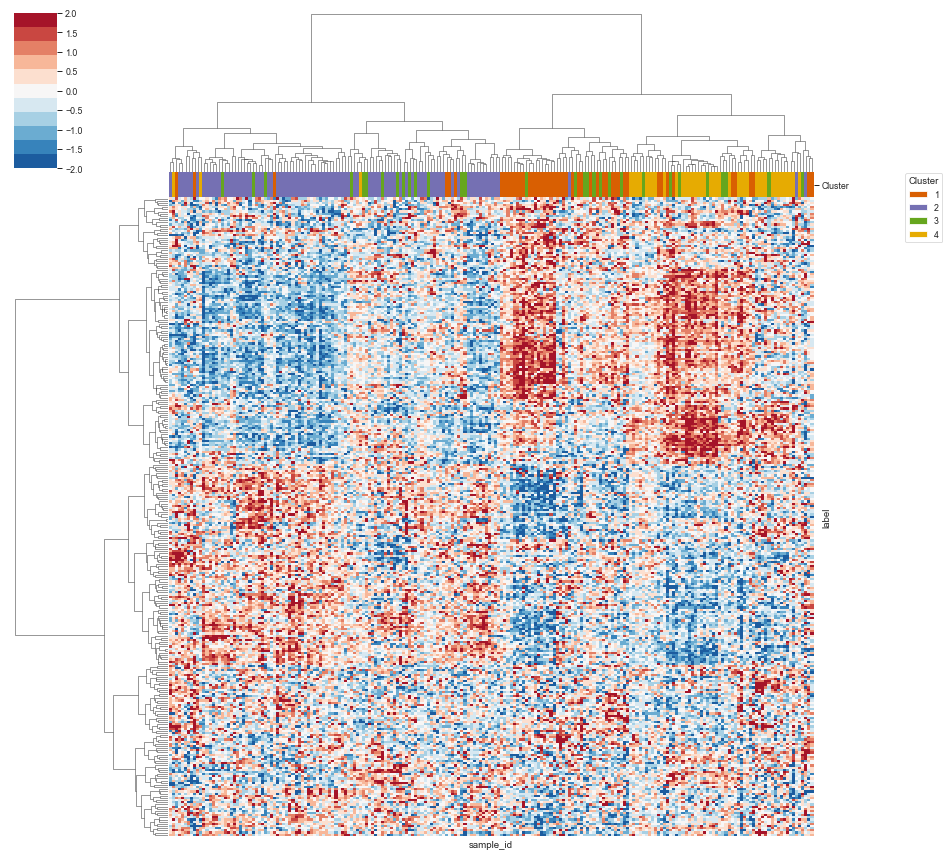

In [56]:
ven_and_pano = plot_all_features(ven_and_pano, yticklabels=False)
plt.savefig("heatmap_features_proteome_vent_pan2.png", bbox_inches='tight', dpi=300)
plt.savefig("heatmap_features_proteome_vent_pan2.pdf", bbox_inches='tight', dpi=300)

In [57]:
vent.proteome

ING4_prot        32
BCL2_prot        29
AAMDC_prot       18
WNK1_prot        17
VAV1_prot        15
                 ..
CLN3-S12sS14s     1
HINT2_prot        1
CTSF_prot         1
GBP4_prot         1
PDHA1_prot        1
Length: 135, dtype: int32

meta NOT subset; don't know how to subset; dropped


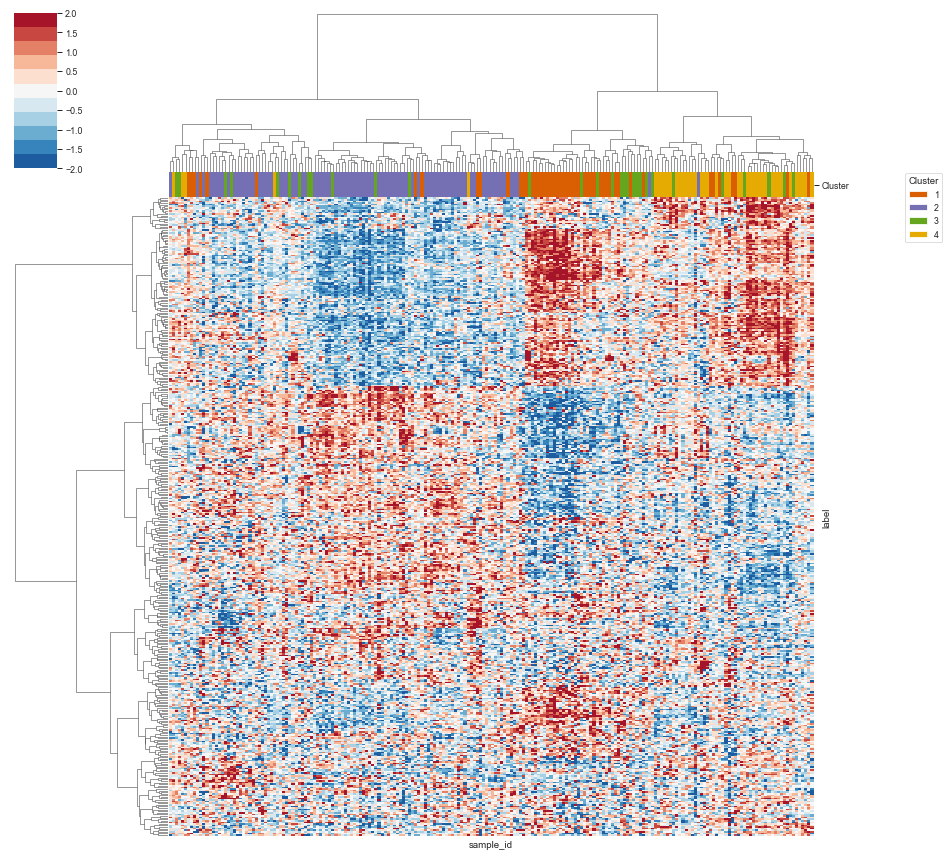

In [179]:
v = set(vent.proteome[vent.proteome>0].index.values)
p = set(pano.proteome[pano.proteome>0].index.values)
s = set(sora.proteome[sora.proteome>0].index.values)
# th = p.intersection(v).intersection(s)
across_all_three = p.union(v).union(s)
across_all_three_df = plot_all_features(across_all_three, yticklabels=False)
plt.savefig("heatmap_combo_drug_features_proteome_3drugs.png", bbox_inches='tight', dpi=300)
plt.savefig("heatmap_combo_drug_features_proteome_3drugs.pdf", bbox_inches='tight', dpi=300)

meta NOT subset; don't know how to subset; dropped


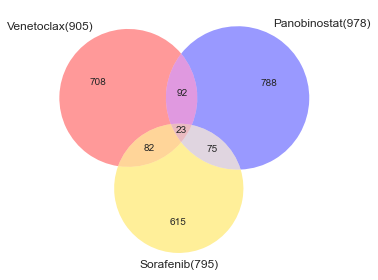

In [123]:
create_venn3(v, p, s, 'Venetoclax', 'Panobinostat', 'Sorafenib', colors=['red', 'blue', 'gold'])
plt.savefig('venn_drug_all3.png', bbox_inches='tight', dpi=300)
plt.savefig('venn_drug_all3.pdf', bbox_inches='tight', dpi=300)



29


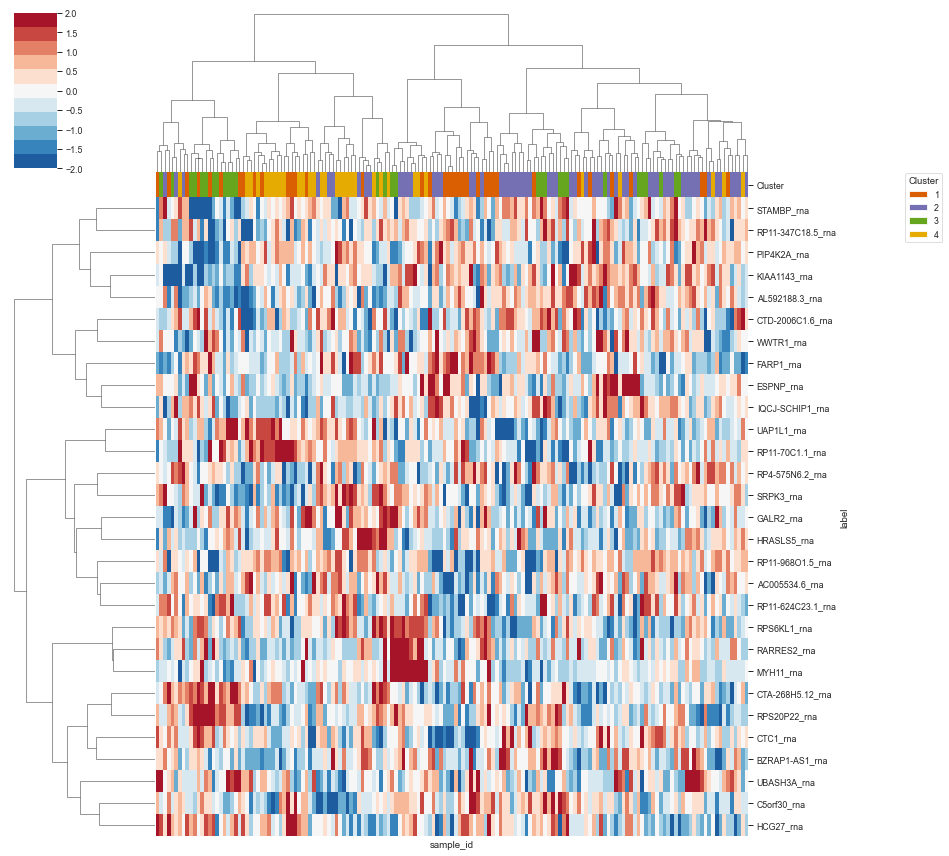

In [18]:
v = set(vent.rna_seq[vent.rna_seq>8].index.values)
p = set(pano.rna_seq[pano.rna_seq>8].index.values)
# pano_venn = p.intersection(v)
pano_venn = p.union(v)
print(len(pano_venn))
pano_venn_features = plot_all_features(pano_venn, yticklabels=True)
# plt.savefig("heatmap_combo_drug_features_pann_venn_overlap.png", bbox_inches='tight', dpi=300)
# plt.savefig("heatmap_combo_drug_features_pann_venn_overlap.pdf", bbox_inches='tight', dpi=300)

278


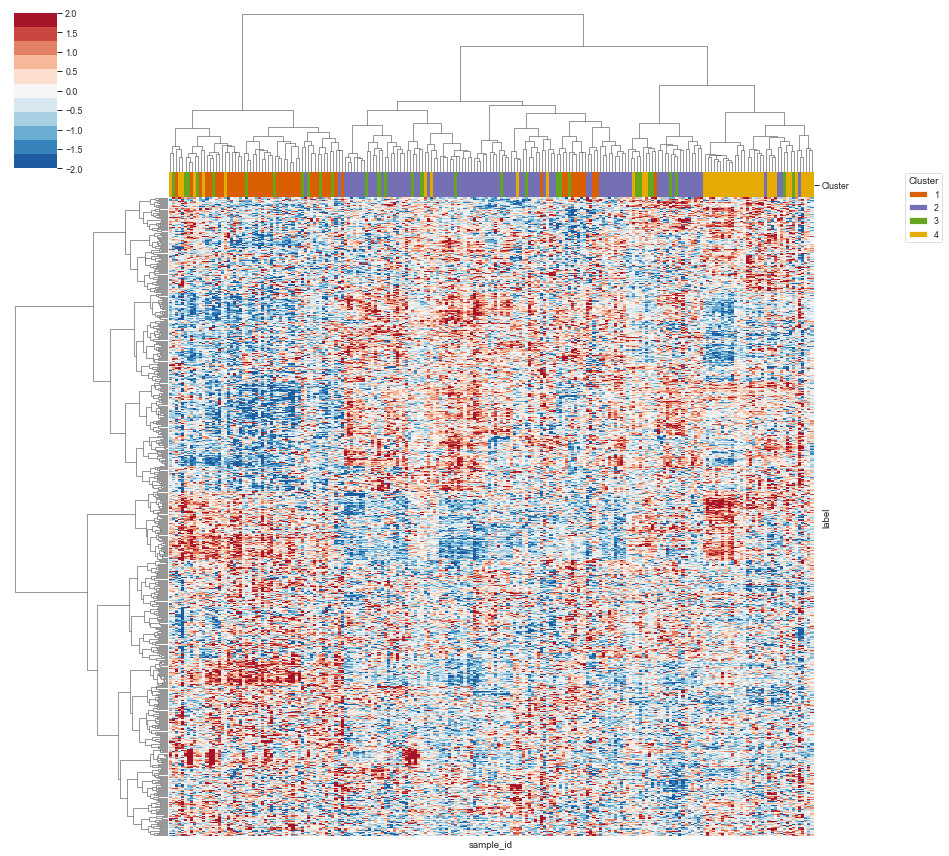

In [19]:
v = set(vent.prot[vent.prot>1].index.values)
p = set(pano.prot[pano.prot>1].index.values)
print(len(v))

pano_venn_features = plot_all_features(v.union(p), yticklabels=False)
# plt.savefig("heatmap_combo_drug_features_pann_venn_overlap.png", bbox_inches='tight', dpi=300)
# plt.savefig("heatmap_combo_drug_features_pann_venn_overlap.pdf", bbox_inches='tight', dpi=300)

135


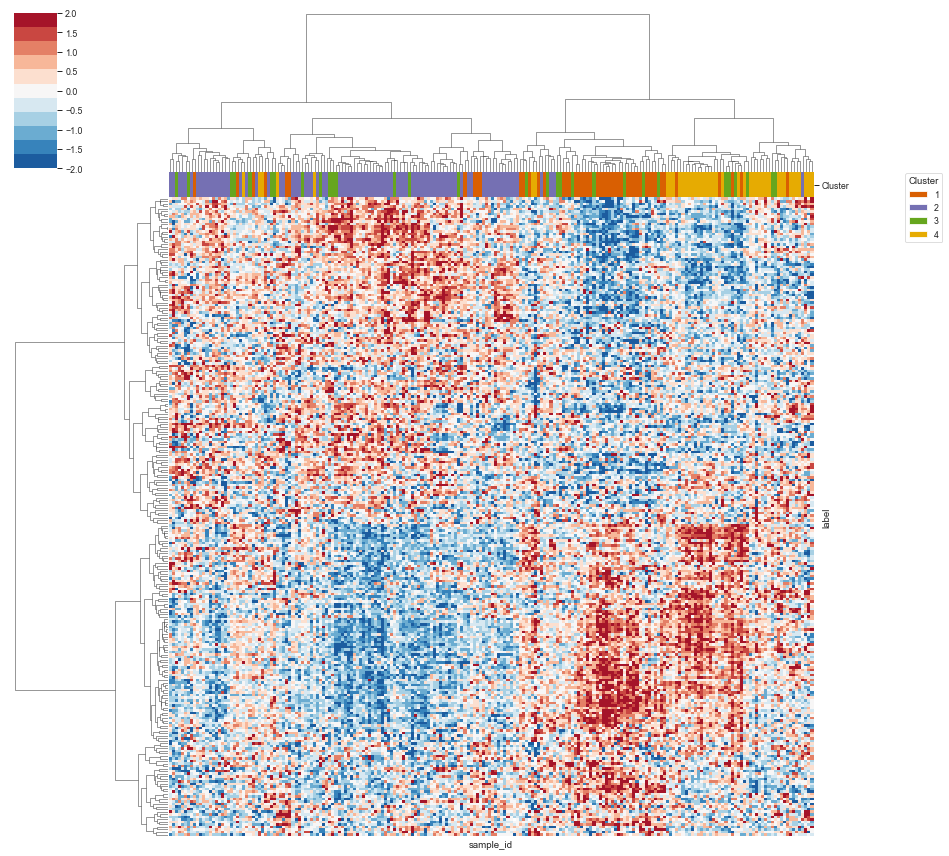

In [89]:
v = set(vent.proteome[vent.proteome>0].index.values)
s = set(sora.proteome[sora.proteome>0].index.values)
print(len(v))

sora_venn_features = plot_all_features(v.union(s), yticklabels=False)
# plt.savefig("heatmap_combo_drug_features_pann_venn_overlap.png", bbox_inches='tight', dpi=300)
# plt.savefig("heatmap_combo_drug_features_pann_venn_overlap.pdf", bbox_inches='tight', dpi=300)

In [142]:
def make_umap_dataset(feature_matrix):
    feature_matrix = feature_matrix[set(feature_matrix.columns.values).intersection(selected_drugs.index.values)]
    umap_scaled = StandardScaler().fit_transform(feature_matrix.fillna(0).T)

    reducer = umap.UMAP(
    #     n_neighbors=10,
        n_components=2,
    #     metric='correlation'

    )
    X_embedded = reducer.fit_transform(umap_scaled)
    principalDf = pd.DataFrame(
        data = X_embedded,
        columns = [f'pc{i}' for i in range(1, X_embedded.shape[1]+1)],
        index=feature_matrix.T.index
    )

    umap_df = pd.concat([principalDf, data.auc_table], axis = 1)
#     umap_df.dropna(subset=['Venetoclax', 'Panobinostat'],  inplace=True)
    return add_sens_col(umap_df)


def add_sens_col(dataset):
    df = dataset.copy()
    df['vent_sens'] = False
    df.loc[df.Venetoclax<100, 'vent_sens'] = True

    df['pano_sens'] = False
    df.loc[df.Panobinostat<100, 'pano_sens'] = True

    df['sor_sens'] = False
    df.loc[df.Sorafenib<100, 'sor_sens'] = True

    # del umap_df['sens_both'] 
    df.loc[df.pano_sens, 'sens_both'] ='Panobinostat'
    df.loc[df.vent_sens, 'sens_both'] = 'Venetoclax'


    df.loc[(df.Panobinostat<100) &  (df.Venetoclax<100), 'sens_both'] = 'Both'
    df.loc[(df.Panobinostat>100) &  (df.Venetoclax>100), 'sens_both'] = 'Neither'

    df.loc[(df.Panobinostat.isna()) &  (df.Venetoclax.isna()), 'sens_both'] ='Not measured'
    return df

In [ ]:
def make_plot(data_set):
      # subplot of samples with drug data applied 
    sub = data_set.loc[data_set.sens_both.isin([
        'Panobinostat', 'Venetoclax',
        'Both', 
    #     'Neither'
    ])]
    f, (ax1, ax2, ax3) = plt.subplots(
        1, 3,
        sharey=True,
        figsize=(12, 3)
    )


    thresh=0.4
    levels=8
    bw_adjust=1

    g1 = sns.kdeplot(
        data=sub,
        x='pc1', y='pc2', color='black',  
        thresh=thresh,
        levels=levels, 
        bw_adjust=bw_adjust,
        fill=False,  
        alpha=0.35,
        hue='Cluster',
        palette=cluster_colors,
        ax=ax1, 
        legend=False
    )

    g1 = sns.scatterplot(
        data=sub,
        x='pc1', y='pc2', 
        hue='Cluster',
        palette=cluster_colors,
        ax=ax1
    )

  
    hue_order = ['Venetoclax', 'Panobinostat', 'Both']
    hue_color = ['blue', 'red', 'black']

    g2 = sns.kdeplot(
        data=sub, 
        x='pc1', y='pc2', 
        color='black',
        thresh=thresh,
        levels=levels, 
        bw_adjust=bw_adjust,
        fill=False,  
        alpha=0.5,
        ax=ax2,  
        hue='sens_both', 
        hue_order = hue_order,
        palette= hue_color, 
        legend=False,
    )
    sns.scatterplot(
        data=sub,
        x='pc1', y='pc2',
        hue='Cluster', 
        ax=ax2,
        legend=False,
#         hue_order = hue_order,
        palette= cluster_colors, 
    );
    
    # plot 3
    sns.kdeplot(
        data=sub,
        x='pc1', y='pc2',
        color='black',   
        thresh=thresh,
        levels=levels, 
        bw_adjust=bw_adjust,
        fill=False,
        hue='sens_both',
        hue_order = hue_order,
        palette= hue_color, 
        alpha=0.5,
        ax=ax3,
        legend=False
    );

    sns.scatterplot(
        data=sub,
        x='pc1', y='pc2',
        hue='sens_both', 
        hue_order = hue_order,
        palette= hue_color, 
        ax=ax3,
        legend=True
    );


    # sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
    ax2.set_xlabel("UMAP projection 1")
    ax1.set_ylabel("UMAP projection 2");
    ax1.set_xlabel('')
    ax3.set_xlabel('')
    ax2.set_ylabel('')
    ax3.set_ylabel('')
    # plt.subplots_adjust()
    f.subplots_adjust(wspace=0)
    handles, labels = ax1.get_legend_handles_labels()
    leg = f.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(.25, 1.15))
    ax1.get_legend().remove()

    xmin = sub['pc1'].min() - 1
    xmax = sub['pc1'].max() +1
    ymin = sub['pc2'].min() -1
    ymax = sub['pc2'].max() +1

    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    handles, labels = ax3.get_legend_handles_labels()
    print(labels)
    leg = f.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(.5, 1.15))
    ax3.get_legend().remove()
    

In [22]:
umap_df_sv = make_umap_dataset(sora_venn_features)
make_plot(umap_df_sv)

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.




['Venetoclax', 'Panobinostat', 'Both']


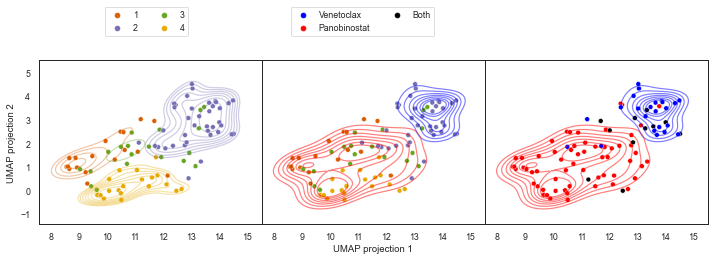

In [90]:
umap_df_sv = make_umap_dataset(sora_venn_features)
make_plot(umap_df_sv)

['Venetoclax', 'Panobinostat', 'Both']


meta NOT subset; don't know how to subset; dropped


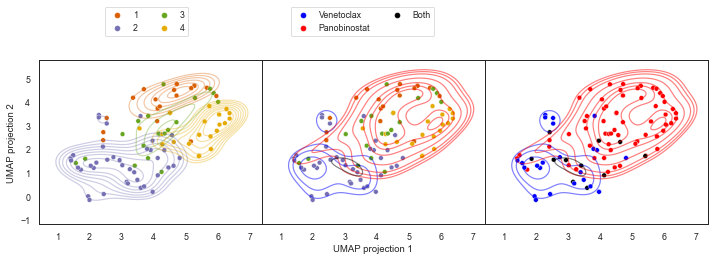

In [25]:
umap_df2 = make_umap_dataset(pano_venn_features)
make_plot(umap_df2)
plt.savefig("umap_combo_pano_venn_features.png", bbox_inches='tight', dpi=300)
plt.savefig("umap_combo_pano_venn_features.pdf", bbox_inches='tight')

In [27]:
def make_2drug_plot():
    f, (ax1, ax2) = plt.subplots(
        1, 2,
        sharey=True,sharex=True,
        figsize=(8, 3)
    )
    # subplot of samples with drug data applied 
    sub = umap_df.loc[umap_df.sens_both.isin([
        'Panobinostat', 'Venetoclax',
        'Both', 
        'Neither'
    ])]

    thresh=0.2
    levels=8
    bw_adjust=.9

    g1 = sns.kdeplot(
        data=sub,
        x='pc1', y='pc2', color='black',  
        thresh=thresh,
        levels=levels, 
        bw_adjust=bw_adjust,
        fill=False,  
        alpha=0.35,
        hue='Cluster',
        palette=cluster_colors,
        ax=ax1, 
        legend=False
    )

    g1 = sns.scatterplot(
        data=sub,
        x='pc1', y='pc2', 
        hue='Cluster',
        palette=cluster_colors,
        ax=ax1
    )


    hue_order = ['Venetoclax', 'Panobinostat', 'Both', 'Neither']
    hue_color = ['red', 'blue', 'black', 'pink']
    hue_color = 'Set1'

    sns.kdeplot(
        data=sub,
        x='pc1', y='pc2',
        color='black',   
      thresh=thresh,
        levels=levels, 
        bw_adjust=bw_adjust,
        fill=False,
        hue='sens_both',
        hue_order = hue_order,
        palette= hue_color, 
        alpha=0.5,
        ax=ax2,
        legend=False
    );

    sns.scatterplot(
        data=sub,
        x='pc1', y='pc2',
        hue='sens_both', 
        hue_order = hue_order,
        palette= hue_color, 
        ax=ax2,
        legend=True
    );


    # sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
    ax2.set_xlabel("UMAP projection 1")
    ax1.set_ylabel("UMAP projection 2");
    ax1.set_xlabel('')
    ax2.set_ylabel('')
    # plt.subplots_adjust()
    f.subplots_adjust(wspace=0)
    handles, labels = ax1.get_legend_handles_labels()
    leg = f.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(.25, 1.15))
    ax1.get_legend().remove()
    xmin = sub['pc1'].min() - 1
    xmax = sub['pc1'].max() +1
    ymin = sub['pc2'].min() -1
    ymax = sub['pc2'].max() +1

    for ax in [ax1, ax2]:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)


    handles, labels = ax2.get_legend_handles_labels()
    print(labels)
    leg = f.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(.75, 1.25))
    ax2.get_legend().remove()
    plt.savefig('sens_landscape_vent_pano_update.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(leg,))
    plt.savefig('sens_landscape_vent_pano_update.pdf', dpi=300, bbox_inches='tight', bbox_extra_artists=(leg,))

In [30]:
umap_df

,pc1,pc2,Panobinostat,Gilteritinib,Venetoclax,Sorafenib,Quizartinib (AC220),Trametinib (GSK1120212),Cluster,vent_sens,pano_sens,sor_sens,sens_both
sample_id,,,,,,,,,,,,,
16-01185,6.774605,0.269298,8.557297e+01,176.513834,70.866972,154.241663,NaN,190.963099,2,True,True,False,Both
15-00872,8.702736,3.028791,7.966568e+01,63.344238,185.459481,NaN,NaN,78.407641,4,False,True,False,Panobinostat
16-01191,6.819031,4.644816,2.140297e+01,135.496002,152.749190,222.133071,136.764958,47.853927,1,False,True,False,Panobinostat
18-00149,6.805305,0.791185,2.097712e+02,NaN,71.865453,NaN,NaN,225.389768,2,True,False,False,Venetoclax
17-00849,5.391583,0.505313,8.085970e-09,17.302078,103.534809,NaN,NaN,193.460212,2,False,True,False,Panobinostat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16-00494,9.170046,3.859786,3.083672e+01,117.936912,179.365780,249.615955,213.840882,214.245733,4,False,True,False,Panobinostat
19-00084,7.404753,0.920331,2.594475e+02,54.941222,111.509383,121.111142,154.298869,67.597756,2,False,False,False,Neither
16-00751,8.414894,4.339486,1.731164e+01,177.730726,234.269209,258.287778,141.748565,33.729989,1,False,True,False,Panobinostat


meta NOT subset; don't know how to subset; dropped


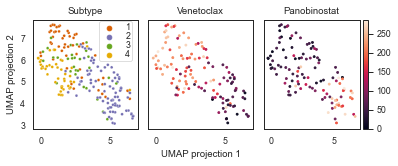

In [100]:
f, (ax1, ax2, ax3) = plt.subplots(
    1, 3,
    sharey=True,sharex=True,
    figsize=(6, 2)
)

# define color map
cmap = sns.color_palette("rocket", as_cmap=True)
thresh=0.24
levels=8
bw_adjust=.9

sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2',
    hue='Cluster', 
#     hue_order = hue_order,
    palette= cluster_colors, 
    ax=ax1,
    s=8,
    legend=True
);

handles, labels = ax1.get_legend_handles_labels()
leg = f.legend(
    handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(.315, .9),
    labelspacing =0,
    borderpad =.2,
    columnspacing = .1
)
ax1.get_legend().remove()



im = ax2.scatter(
    umap_df['pc1'], umap_df['pc2'],
    c=umap_df['Venetoclax'], 
    cmap=cmap, 
    s=4
)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# f.colorbar(im, cax=cax, orientation='vertical')

im = ax3.scatter(
    umap_df['pc1'], umap_df['pc2'],
    c=umap_df['Panobinostat'],
    cmap=cmap,
    s=4
)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')


ax1.set_title("Subtype")
ax2.set_title("Venetoclax")
ax3.set_title("Panobinostat")

ax1.set_ylabel("UMAP projection 2");
ax2.set_xlabel("UMAP projection 1")

ax1.set_xlabel('')
ax2.set_ylabel('')

plt.subplots_adjust()
f.subplots_adjust(wspace=.1)
plt.savefig('umap_reg_features_drug_colored2.png', bbox_inches='tight')
plt.savefig('umap_reg_features_drug_colored2.pdf', bbox_inches='tight')

In [101]:
umap_df

,pc1,pc2,Panobinostat,Gilteritinib,Venetoclax,Sorafenib,Quizartinib (AC220),Trametinib (GSK1120212),Cluster,vent_sens,pano_sens,sor_sens,sens_both
sample_id,,,,,,,,,,,,,
14-00514,2.435299,7.138106,NaN,NaN,NaN,NaN,NaN,220.445526,1,False,False,False,Not measured
12-00268,4.439474,4.865898,NaN,NaN,NaN,235.977408,212.102851,140.455497,1,False,False,False,Not measured
16-01185,4.830599,4.012947,85.572969,176.513834,70.866972,154.241663,NaN,190.963099,2,True,True,False,Both
15-00872,1.228925,5.131036,79.665681,63.344238,185.459481,NaN,NaN,78.407641,4,False,True,False,Panobinostat
16-01191,0.692042,7.545756,21.402974,135.496002,152.749190,222.133071,136.764958,47.853927,1,False,True,False,Panobinostat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17-00881,1.934691,6.038603,10.600378,100.552947,221.136205,166.892503,NaN,183.082036,3,False,True,False,Panobinostat
15-00837,3.114639,6.070137,84.556858,83.011682,159.507944,182.356890,117.845839,53.161958,2,False,True,False,Panobinostat
12-00032,1.273529,6.596550,NaN,NaN,NaN,162.410566,111.398230,88.662770,1,False,False,False,Not measured


In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4,
    sharey=True,sharex=True,
    figsize=(8, 2)
)

# define color map
cmap = sns.color_palette("rocket", as_cmap=True)
thresh=0.24
levels=8
bw_adjust=.9

sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2',
    hue='Cluster', 
#     hue_order = hue_order,
    palette= cluster_colors, 
    ax=ax1,
    s=8,
    legend=True
);

handles, labels = ax1.get_legend_handles_labels()
leg = f.legend(
    handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(.265, .9),
    labelspacing =0,
    borderpad =.2,
    columnspacing = .1
)
ax1.get_legend().remove()



im = ax2.scatter(
    umap_df['pc1'], umap_df['pc2'],
    c=umap_df['Venetoclax'], 
    cmap=cmap, 
    s=4
)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# f.colorbar(im, cax=cax, orientation='vertical')

im = ax3.scatter(
    umap_df['pc1'], umap_df['pc2'],
    c=umap_df['Panobinostat'],
    cmap=cmap,
    s=4
)
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# f.colorbar(im, cax=cax, orientation='vertical')

im = ax4.scatter(
    umap_df['pc1'], umap_df['pc2'],
    c=umap_df['Sorafenib'],
    cmap=cmap,
    s=4
)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax1.set_title("Subtype")
ax2.set_title("Venetoclax")
ax3.set_title("Panobinostat")
ax4.set_title("Sorafenib")

ax1.set_ylabel("UMAP projection 2");
ax3.set_xlabel("UMAP projection 1")

ax1.set_xlabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

plt.subplots_adjust()
f.subplots_adjust(wspace=.1)
plt.savefig('umap_reg_features_drug_colored_3drugs.png', bbox_inches='tight')
plt.savefig('umap_reg_features_drug_colored_3drugs.pdf', bbox_inches='tight')

Index(['pc1', 'pc2', '17-AAG (Tanespimycin)', 'A-674563', 'ABT-737',
       'AGI combo', 'AGI combo - Crizotinib', 'AGI combo - Quizartinib',
       'AGI combo - Sorafenib', 'AGI-5198',
       ...
       'k=5', 'k=6', 'k=7', 'k=8', 'Cluster', 'Cluster', 'vent_sens',
       'pano_sens', 'sor_sens', 'sens_both'],
      dtype='object', length=340)

In [180]:
umap_df = make_umap_dataset(across_all_three_df)
# make_plot(umap_df)
umap_df.head()
drugs = [
    'Venetoclax', 
    'Panobinostat',
    'Sorafenib',
#     'Sorafenib - Venetoclax',
    'Venetoclax - Panobinostat',
    'Sorafenib - Panobinostat'
]
umap_df = umap_df[['pc1', 'pc2', 'Cluster'] + drugs]
umap_df

,pc1,pc2,Cluster,Venetoclax,Panobinostat,Sorafenib,Venetoclax - Panobinostat,Sorafenib - Panobinostat
sample_id,,,,,,,,
14-00514,3.768855,11.287133,1,NaN,NaN,NaN,NaN,NaN
12-00268,2.134026,11.533321,1,NaN,NaN,235.977408,NaN,NaN
16-01185,0.364643,12.397884,2,70.866972,85.572969,154.241663,2.810348e+01,140.279580
15-00872,3.616121,14.037830,4,185.459481,79.665681,NaN,8.085970e-09,90.007763
16-01191,5.551298,11.561152,1,152.749190,21.402974,222.133071,NaN,49.670155
...,...,...,...,...,...,...,...,...
17-00881,4.076942,12.320616,3,221.136205,10.600378,166.892503,NaN,NaN
15-00837,2.612711,12.844278,2,159.507944,84.556858,182.356890,4.479874e-01,72.294748
12-00032,4.737318,12.377609,1,NaN,NaN,162.410566,NaN,NaN


0 1
0 2
0 3
1 1
1 2


meta NOT subset; don't know how to subset; dropped


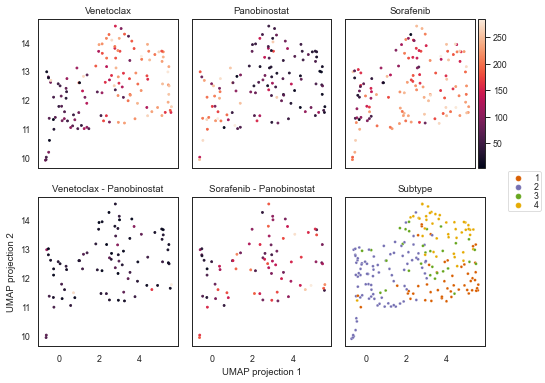

In [181]:
f, axes = plt.subplots(
    2, 3,
    sharey=True,sharex=True,
    figsize=(8, 6)
)

# define color map
cmap = sns.color_palette("rocket", as_cmap=True)
thresh=0.24
levels=8
bw_adjust=.9
ax1 = axes[-1,-1]

sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2',
    hue='Cluster', 
#     hue_order = hue_order,
    palette= cluster_colors, 
    ax=ax1,
    s=8,
    legend=True
);

handles, labels = ax1.get_legend_handles_labels()
leg = f.legend(
    handles, labels, loc='center right', ncol=1,# bbox_to_anchor=(.265, .9),
    labelspacing =0,
    borderpad =.2,
    columnspacing = .1
)
ax1.get_legend().remove()
ax1.set_title("Subtype")


x_coord = 0
y_coord = 0

for i in drugs:
    if y_coord > 2:
        x_coord += 1
        y_coord = 0
    
    ax = axes[x_coord, y_coord]
    im = ax.scatter(
        umap_df['pc1'], 
        umap_df['pc2'],
        c=umap_df[i], 
        cmap=cmap, 
        s=4
    )
    ax.set_title(i)
    y_coord+=1
    print(x_coord, y_coord)
divider = make_axes_locatable(axes[0, -1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

axes[1, 0].set_ylabel("UMAP projection 2");
axes[1, 1].set_xlabel("UMAP projection 1")

ax1.set_xlabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')


f.subplots_adjust(wspace=.1)
plt.savefig('umap_reg_features_drug_colored_3drugs_combo.png', bbox_inches='tight')
plt.savefig('umap_reg_features_drug_colored_3drugs_combo.pdf', bbox_inches='tight')

In [125]:
umap_df.columns

Index(['pc1', 'pc2', 'Panobinostat', 'Gilteritinib', 'Venetoclax', 'Sorafenib',
       'Quizartinib (AC220)', 'Trametinib (GSK1120212)', 'Cluster',
       'vent_sens', 'pano_sens', 'sor_sens', 'sens_both'],
      dtype='object')

## Enrichment analysis on features

In [83]:
from magine.enrichment.enrichr import Enrichr
e = Enrichr()

def plot_enrichment(features, drug):
    
    proteins = []
    for i in features:
        proteins.append(i.split('_')[0])
    enresult = e.run(proteins, gene_set_lib='Reactome_2022')
    enresult['sample_id'] = drug
    enresult.term_name = enresult.term_name.str.split('_').str.get(0)
    enresult.sig.remove_redundant(threshold=.7).heatmap(
        convert_to_log=True,
        linewidths=0.01,
        figsize=(4, 8),
        y_tick_labels=True, 
        cluster_by_set=False
    );
    return enresult

In [84]:
p_enrich = plot_enrichment(p, 'Panobinostat')
v_enrich = plot_enrichment(v, 'Venetoclax')
s_enrich = plot_enrichment(s, 'Sorafenib')

55973022
Number of rows went from 0 to 0
No terms match subset
55973023
Number of rows went from 0 to 0
No terms match subset
55973024
Number of rows went from 0 to 0
No terms match subset


In [27]:
all_enrich = pd.concat([p_enrich, v_enrich, s_enrich], ignore_index=True)

Number of rows went from 53 to 21


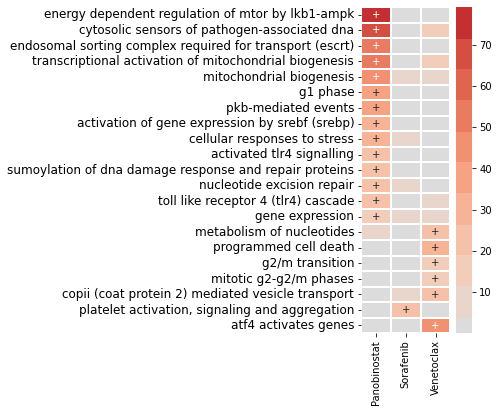

In [46]:
g = all_enrich.require_n_sig(
    n_sig=1
).remove_redundant(
    threshold=.4, sort_by='n_genes',
    level='sample'
).heatmap(
    linewidths=0.01,
    convert_to_log=False,
    cluster_by_set=False,
    y_tick_labels=True,
    
    figsize=(2,6)
);

g.axes[0].set_yticklabels(
        g.axes[0].get_yticklabels(), 
        size = 12
)
# g.axes[0].set_xticklabels(
#         g.axes[0].get_xticklabels(), 
#         size = 12, rotation=45
# )
plt.savefig('pan_vent_sor_compare_non_compressed.png', dpi=300, bbox_inches='tight')
plt.savefig('pan_vent_sor_compare_non_compressed.pdf', dpi=300, bbox_inches='tight')

In [45]:
s_enrich.term_to_genes('platelet degranulation')

{'A2M',
 'ACTN2',
 'ALB',
 'CALU',
 'CD9',
 'CLU',
 'FGB',
 'FN1',
 'ITIH4',
 'PLG',
 'PPIA',
 'SERPINA1',
 'SOD1',
 'TIMP1'}